In [1]:
import math

import cv2
import numpy as np
import tritonclient.http as httpclient

SAVE_INTERMEDIATE_IMAGES = False


def detection_preprocessing(image: cv2.Mat) -> np.ndarray:
    inpWidth = 640
    inpHeight = 480

    # pre-process image
    blob = cv2.dnn.blobFromImage(
        image, 1.0, (inpWidth, inpHeight), (123.68, 116.78, 103.94), True, False
    )
    blob = np.transpose(blob, (0, 2, 3, 1))
    return blob


def detection_postprocessing(scores, geometry, preprocessed_image):
    def fourPointsTransform(frame, vertices):
        vertices = np.asarray(vertices)
        outputSize = (100, 32)
        targetVertices = np.array(
            [
                [0, outputSize[1] - 1],
                [0, 0],
                [outputSize[0] - 1, 0],
                [outputSize[0] - 1, outputSize[1] - 1],
            ],
            dtype="float32",
        )

        rotationMatrix = cv2.getPerspectiveTransform(vertices, targetVertices)
        result = cv2.warpPerspective(frame, rotationMatrix, outputSize)
        return result

    def decodeBoundingBoxes(scores, geometry, scoreThresh=0.5):
        detections = []
        confidences = []

        ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ########
        assert len(scores.shape) == 4, "Incorrect dimensions of scores"
        assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
        assert scores.shape[0] == 1, "Invalid dimensions of scores"
        assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
        assert scores.shape[1] == 1, "Invalid dimensions of scores"
        assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
        assert (
            scores.shape[2] == geometry.shape[2]
        ), "Invalid dimensions of scores and geometry"
        assert (
            scores.shape[3] == geometry.shape[3]
        ), "Invalid dimensions of scores and geometry"
        height = scores.shape[2]
        width = scores.shape[3]
        for y in range(0, height):
            # Extract data from scores
            scoresData = scores[0][0][y]
            x0_data = geometry[0][0][y]
            x1_data = geometry[0][1][y]
            x2_data = geometry[0][2][y]
            x3_data = geometry[0][3][y]
            anglesData = geometry[0][4][y]
            for x in range(0, width):
                score = scoresData[x]

                # If score is lower than threshold score, move to next x
                if score < scoreThresh:
                    continue

                # Calculate offset
                offsetX = x * 4.0
                offsetY = y * 4.0
                angle = anglesData[x]

                # Calculate cos and sin of angle
                cosA = math.cos(angle)
                sinA = math.sin(angle)
                h = x0_data[x] + x2_data[x]
                w = x1_data[x] + x3_data[x]

                # Calculate offset
                offset = [
                    offsetX + cosA * x1_data[x] + sinA * x2_data[x],
                    offsetY - sinA * x1_data[x] + cosA * x2_data[x],
                ]

                # Find points for rectangle
                p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
                p3 = (-cosA * w + offset[0], sinA * w + offset[1])
                center = (0.5 * (p1[0] + p3[0]), 0.5 * (p1[1] + p3[1]))
                detections.append((center, (w, h), -1 * angle * 180.0 / math.pi))
                confidences.append(float(score))

        # Return detections and confidences
        return [detections, confidences]

    scores = scores.transpose(0, 3, 1, 2)
    geometry = geometry.transpose(0, 3, 1, 2)
    frame = np.squeeze(preprocessed_image, axis=0)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    [boxes, confidences] = decodeBoundingBoxes(scores, geometry)
    indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, 0.5, 0.4)

    cropped_list = []
    cv2.imwrite("frame.png", frame)
    count = 0
    for i in indices:
        # get 4 corners of the rotated rect
        count += 1
        vertices = cv2.boxPoints(boxes[i])
        cropped = fourPointsTransform(frame, vertices)
        cv2.imwrite(str(count) + ".png", cropped)
        cropped = np.expand_dims(cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY), axis=0)

        cropped_list.append(((cropped / 255.0) - 0.5) * 2)
    cropped_arr = np.stack(cropped_list, axis=0)

    # Only keep the first image, since the models don't currently allow batching.
    # See part 2 for enabling batch sizes > 0
    return cropped_arr[None, 0]


def recognition_postprocessing(scores: np.ndarray) -> str:
    text = ""
    alphabet = "0123456789abcdefghijklmnopqrstuvwxyz"

    scores = np.transpose(scores, (1, 0, 2))

    for i in range(scores.shape[0]):
        c = np.argmax(scores[i][0])
        if c != 0:
            text += alphabet[c - 1]
        else:
            text += "-"
    # adjacent same letters as well as background text must be removed
    # to get the final output
    char_list = []
    for i, char in enumerate(text):
        if char != "-" and (not (i > 0 and char == text[i - 1])):
            char_list.append(char)
    return "".join(char_list)

In [2]:
# Setting up client
client = httpclient.InferenceServerClient(url="localhost:8000")



In [4]:
# Read image and create input object
raw_image = cv2.imread("./img1.jpg")
preprocessed_image = detection_preprocessing(raw_image)
detection_input = httpclient.InferInput(
    "input_images:0", preprocessed_image.shape, datatype="FP32"
)
detection_input.set_data_from_numpy(preprocessed_image, binary_data=True)


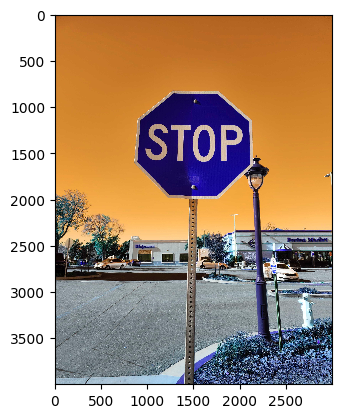

In [31]:
from matplotlib import pyplot as plt
plt.imshow(raw_image, interpolation='nearest')
plt.show()

In [5]:

# Query the server
detection_response = client.infer(
    model_name="text_detection", inputs=[detection_input]
)

In [6]:
detection_response

In [7]:
# Process responses from detection model
scores = detection_response.as_numpy("feature_fusion/Conv_7/Sigmoid:0")
geometry = detection_response.as_numpy("feature_fusion/concat_3:0")
cropped_images = detection_postprocessing(scores, geometry, preprocessed_image)

In [8]:
cropped_images

array([[[[-1.6995714, -1.6956496, -1.6995714, ..., -1.6258246,
          -1.6226536, -1.6175525],
         [-1.6995714, -1.6971203, -1.6903965, ..., -1.6319828,
          -1.6226536, -1.6209533],
         [-1.6917589, -1.6934352, -1.6837938, ..., -1.6070197,
          -1.6230263, -1.6226536],
         ...,
         [-1.6567712, -1.6564649, -1.6557893, ..., -1.550389 ,
          -1.5592496, -1.5673227],
         [-1.6567712, -1.6567712, -1.6567712, ..., -1.5647415,
          -1.5592496, -1.5592496],
         [-1.6567712, -1.6567713, -1.6567712, ..., -1.536762 ,
          -1.5608735, -1.5494764]]]], dtype=float32)

In [11]:
#pip install matplotlib

In [26]:
cropped_images_flattened = cropped_images.reshape(-1, cropped_images.shape[-1])
cropped_images_flattened.shape

(32, 100)

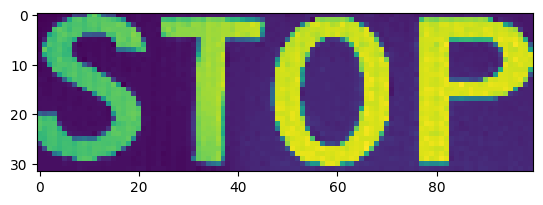

In [27]:
from matplotlib import pyplot as plt
plt.imshow(cropped_images_flattened, interpolation='nearest')
plt.show()

In [32]:
# Create input object for recognition model
recognition_input = httpclient.InferInput(
    "input.1", cropped_images.shape, datatype="FP32"
)
recognition_input.set_data_from_numpy(cropped_images, binary_data=True)

# Query the server
recognition_response = client.infer(
    model_name="text_recognition", inputs=[recognition_input]
)

# Process response from recognition model
final_text = recognition_postprocessing(recognition_response.as_numpy("308"))

print(final_text)

stop
